In [2]:
library(tidyverse)
library(magrittr)
library(ggplot2)
library(rscones2)

wd <- "/bioinfo/users/hcliment/easyGWASCore/data/testing/scones/chisq/"

pedBasename = paste0(wd, "genotype")
phenoFile = paste0(wd, "phenotype.txt")
netFile = paste0(wd, "network.txt")
encoding = 0
maf = 0.05

d <- readBio(pedBasename, phenoFile, netFile, encoding, maf)

SKAT <- 0
CHISQ <- 1

CONSISTENCY <- 1
AICc <- 2

In [26]:
truth <- read_tsv(paste0(pedBasename, ".map"), col_names = F) %>% 
    head(20) %>% 
    set_colnames(c("chr","name","godknows","pos")) %>%
    select(chr,pos)

Parsed with column specification:
cols(
  X1 = col_integer(),
  X2 = col_character(),
  X3 = col_integer(),
  X4 = col_integer()
)


We need:

* Remove the remove rows in CHISQ calculation?

In [11]:
# AICc
chisq.sets = list(test_statistic = CHISQ, gridsearch_depth = 3, selection_criterion = AICc)
chisq <- runScones(d$X, d$Y, d$net, chisq.sets)

skat.sets = list(gridsearch_depth = 3, selection_criterion = AICc)
skat <- runScones(d$X, d$Y, d$net, skat.sets)

[1] 47

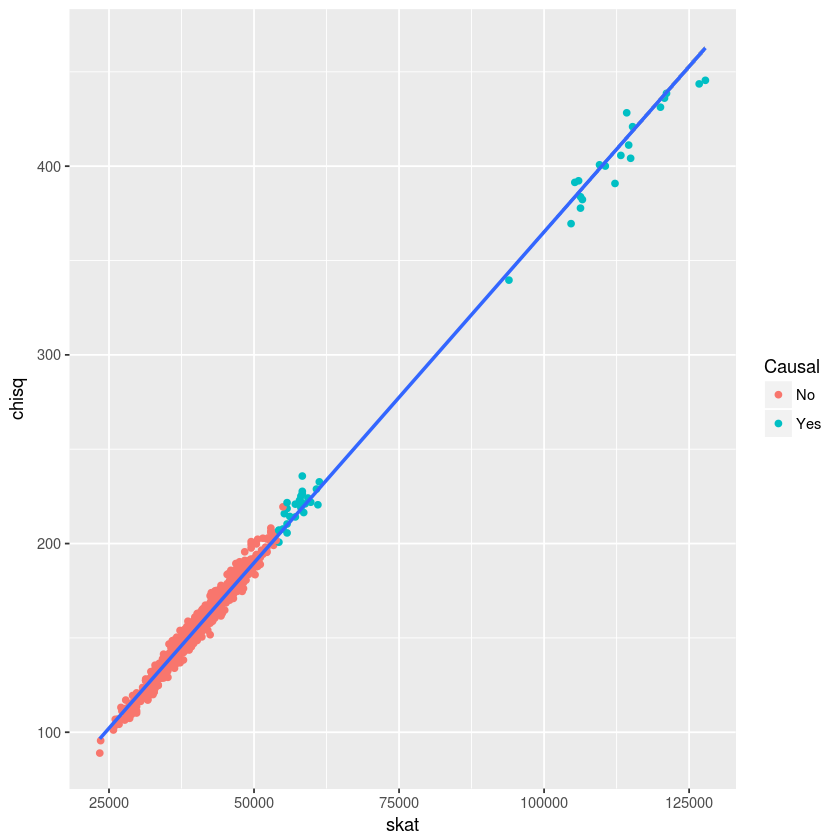

In [28]:
data.frame(skat = skat$scores, chisq = chisq$scores, causal = skat$indicator) %>%
    mutate(Causal = ifelse(causal == 1, "Yes", "No")) %>%
    ggplot(aes(x = skat, y = chisq)) +
        geom_point(aes(color = Causal)) + 
        geom_smooth(method = lm, alpha = 0.5)

sum(skat$indicator)

In [14]:
sum(chisq$indicator)

[1] 960

CHISQ selects all the SNPs somehow. SKAT does seem to select a subset of the SNPs, which partially includes the true positives. Let's see how they are connected:

Parsed with column specification:
cols(
  X1 = col_integer(),
  X2 = col_integer(),
  X3 = col_integer(),
  X4 = col_integer()
)
Warning message in `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, :
“duplicated levels in factors are deprecated”Warning message in `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, :
“duplicated levels in factors are deprecated”Warning message in `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, :
“duplicated levels in factors are deprecated”Warning message in `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, :
“duplicated levels in factors are deprecated”Warning message in `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, :
“duplicated levels in factors are deprecated”Warning message in `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, :
“duplicated levels in 

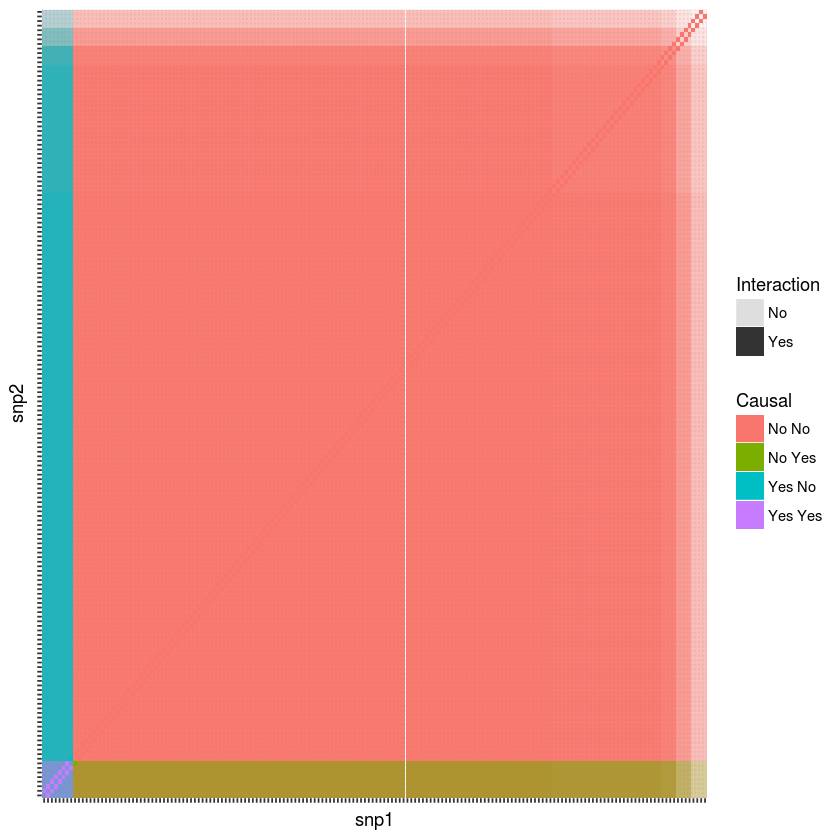

In [27]:
map <- read_tsv(paste0(pedBasename, ".map"), col_names = F) %>% 
    set_colnames(c("chr","snp","godknows","pos")) %>%
    mutate(causal = pos %in% truth$pos & chr %in% truth$chr,
           detected = as.logical(skat$indicator),
           status = "TN",
           status = ifelse(causal & detected, "TP", status),
           status = ifelse(causal & ! detected, "FN", status),
           status = ifelse(! causal & detected, "FP", status) )

net <- read_tsv(netFile, col_names = F) %>% 
    set_colnames(c("chr","pos","chr2","pos2")) %>%
    merge(map, by = c("chr", "pos")) %>%
    merge(map, by.x = c("chr2", "pos2"), by.y = c("chr", "pos")) %>%
    arrange(chr, pos)

net %>% select(pos,pos2) %>% table  %>%
  apply(1, function(x) x > 0) %>% as.data.frame()  %>%
  set_colnames(., paste0("rs", colnames(.))) %>% mutate(., rs = colnames(.)) %>%
  gather(rs) %>%
  set_colnames(c("snp1", "snp2", "interaction")) %>%
  merge(scores %>% select(snp,chr,pos,causal), by.x="snp1", by.y="snp") %>%
  merge(scores %>% select(snp,chr,pos,causal), by.x="snp2", by.y="snp", suffixes = c("1", "2")) %>%
  arrange(chr1,pos1,chr2,pos2) %>%
  mutate(snp1 = factor(snp1, levels = scores %>% arrange(chr,pos) %>% .$snp),
        snp2 = factor(snp2, levels = scores %>% arrange(chr,pos) %>% .$snp),
        interaction = ifelse(interaction, "Yes", "No")) %>%
  ggplot(aes(x=snp1, y=snp2, fill=paste(causal1, causal2), alpha=interaction)) +
    geom_tile() +
    theme(axis.text.x=element_blank(), axis.text.y=element_blank()) + 
    labs(fill = "Causal", alpha = "Interaction")

In [29]:
paste0(pedBasename, ".map")

[1] "/bioinfo/users/hcliment/easyGWASCore/data/testing/scones/chisq/genotype.map"